# Computer Vision: Assignment 3 Part 2 - Image De-blurring by Supervised Learning [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

# GUIDELINES

## 1. Problem Definition

### (1) Data

- input data consists of `training` data and `testing` data
- `training` data is used for training neural network
- `testing` data is used for validating the trained neural network
- both `training` and `testing` data have the same structure that consists of a pair of clean image 'x' and its corrupted blurry image 'y'
- images are 2-dimensional matrices of the size `256 x 256` (gray-scale images)

### (2) Neural Network

- A simple neural network is provided, in the form of auto-encoder that consists of an encoder and a decoder
- a typical encoder consists of layers including convolution, pooling/striding, batch normalization, activation
- a typical decoder consists of layers including upsampling, convolution, batch normalization, activation
- Sigmoid is a typical final activation function for the $[0,1]$-scaled network output
  
### (3) Loss

- The network uses the mean squared error (the squared `L_2`-norm) between the prediction (de-blurred) and the ground truth (original)

### (4) Optimization

- use any optimization algorithms such as SGD, Adam, AdaGrad, RMSProp

### (5) Training

- training aims to determine the model parameters of the neural network and its associated loss function is optimized using the training data

### (6) Testing

- testing aims to validate the generality of the trained neural network using the testing data

### (7) Evaluation metrics

- use PSNR and SSIM for the evaluation of the performance
- PSNR is computed by `PSNR = 10 * \log_{10} \left( \frac{MAX(IMAGE)^2}{MSE} \right)`
- SSIM (structural similarity index) is following  Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: From error visibility to structural similarity. https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf



## 3. General goal: 

Work on the model to get the best performance (PSNR, SSIM) on the testing data. You may play around, for example , with the following(but not necessarily with all!):

- neural network architecture
- optimizer
- loss function
- data augmentation
- initialization
- number of epochs
- size of mini-batch
- learning-rate
- weight-decay
- early stopping
- ..
  
## 4. Submission

### (1) this notebook file (with cell output results)
### (2) the file model.pth (saved below) which holds the weights of your final model

## 5. Grading

Will be based on:

- accuracy (PSNR, SSIM) performance on a held-out test set that we will check
- explanation (last text block) on what were the architectural and other choices that you made 
- answer of last 'question' at the bottom of the file




## install packages

In [111]:
# You may add here anything needed

## import libraries

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log10
from tqdm import tqdm
import random
import os
from skimage.metrics import structural_similarity
from ignite.metrics import SSIM
from ignite.engine import Engine

## download dataset

In [113]:
filename_data   = './data/ex3_P2_data_public.npz'
if os.path.exists(filename_data):
  print('data already exists')
else:
  print('downloading data...')
  !mkdir './data'
  !wget -O './data/ex3_P2_data_public.npz' https://www.cs.haifa.ac.il/~skorman/ex3_P2_data_public.npz
  

data already exists


## load data

In [114]:
filename_data   = './data/ex3_P2_data_public.npz'
data            = np.load(filename_data)

original_train  = data['original_train']
blur_train      = data['blur_train']

original_test   = data['original_test']
blur_test       = data['blur_test']

num_data_train  = original_train.shape[0]
num_data_test   = original_test.shape[0]


print('*************************************************')
print('size of original_train :', original_train.shape)
print('size of blur_train :', blur_train.shape)
print('*************************************************')
print('size of original_test :', original_test.shape)
print('size of blur_test :', blur_test.shape)
print('*************************************************')
print('number of training image :', original_train.shape[0])
print('height of training image :', original_train.shape[1])
print('width of training image :', original_train.shape[2])
print('*************************************************')
print('number of testing image :', original_test.shape[0])
print('height of testing image :', original_test.shape[1])
print('width of testing image :', original_test.shape[2])
print('*************************************************')


*************************************************
size of original_train : (200, 256, 256)
size of blur_train : (200, 256, 256)
*************************************************
size of original_test : (50, 256, 256)
size of blur_test : (50, 256, 256)
*************************************************
number of training image : 200
height of training image : 256
width of training image : 256
*************************************************
number of testing image : 50
height of testing image : 256
width of testing image : 256
*************************************************


## hyper-parameters

In [115]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 200
size_minibatch  = 50
learning_rate   = 0.05
weight_decay    = 0.0000001

# any others?

## data loader (including augmentations)

In [116]:
class dataset(Dataset):
    
    def __init__(self, original, blur, transform=False):
        
        self.original   = original
        self.blur       = blur 
        self.transform = transform
    
    def __getitem__(self, index):
        
        original    = self.original[index]
        blur        = self.blur[index]
        
        original    = torch.FloatTensor(original).unsqueeze(dim=0)
        blur        = torch.FloatTensor(blur).unsqueeze(dim=0)

        if self.transform:

            crop_size = [64, 64]
            # random crop
            top         = random.randint(0, original.shape[1] - crop_size[0])
            left        = random.randint(0, original.shape[2] - crop_size[1])
            original    = transforms.functional.crop(original, top, left, crop_size[0], crop_size[1])
            blur        = transforms.functional.crop(blur, top, left, crop_size[0], crop_size[1])
            
            # anything else?

        return (original, blur)
    
    def __len__(self):
        
        return self.original.shape[0]

## construct datasets and dataloaders for training and testing

In [117]:
dataset_train_transform = dataset(original_train, blur_train, transform=True)
dataset_train           = dataset(original_train, blur_train)
dataset_test            = dataset(original_test, blur_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## helper function for visualizing data

In [118]:
# visualize a sample of the data
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 2
    size_row = 2

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    if nRow==1:
        for j in range(nCol):
            index   = index_data[j]

            axes[j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[j].xaxis.set_visible(False)
            axes[j].yaxis.set_visible(False)
    else:        
        for i in range(nRow):
            for j in range(nCol):
                k       = i * nCol + j
                index   = index_data[k]

                axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
                axes[i, j].xaxis.set_visible(False)
                axes[i, j].yaxis.set_visible(False)

    plt.show()

## visualize your (augmented) training set

sample from augmented batch 0   image dims torch.Size([1, 64, 64])


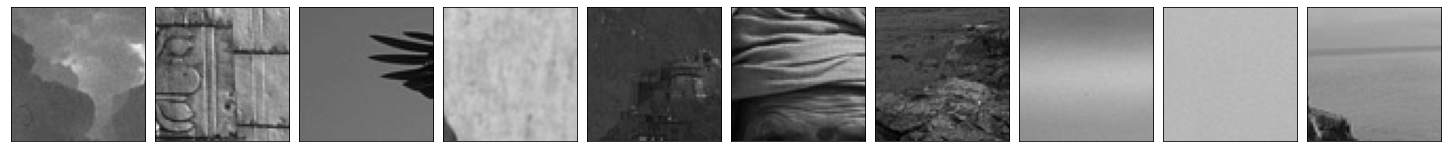

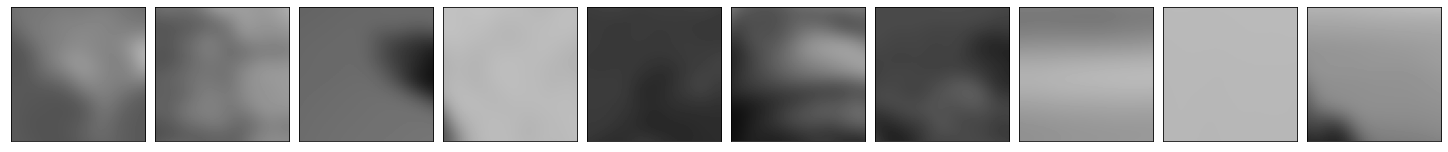

sample from augmented batch 1   image dims torch.Size([1, 64, 64])


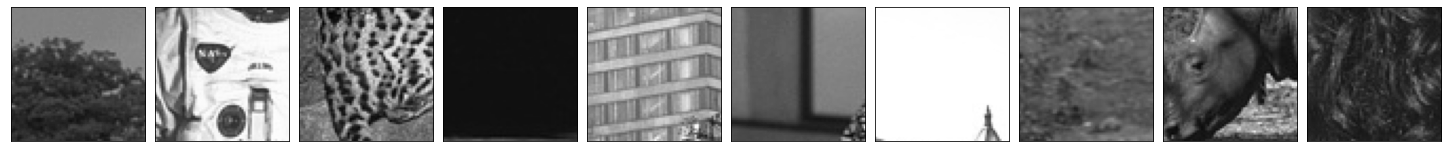

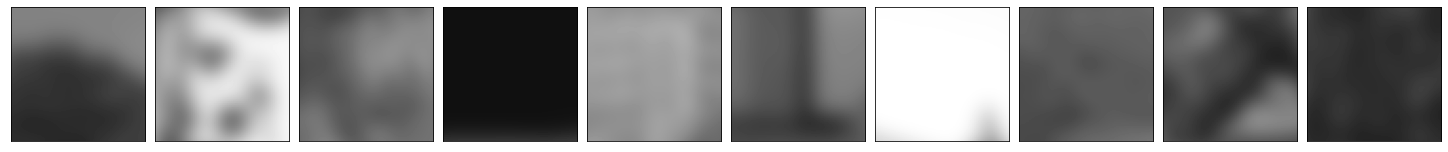

sample from augmented batch 2   image dims torch.Size([1, 64, 64])


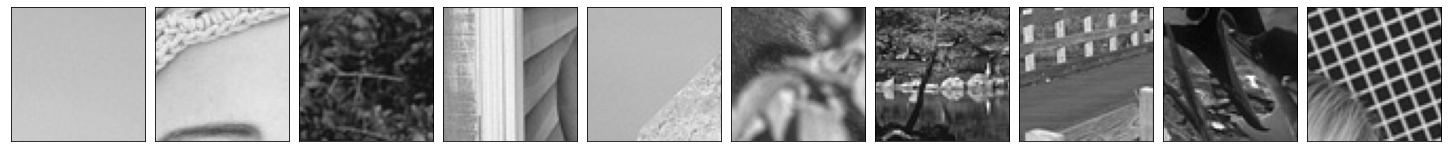

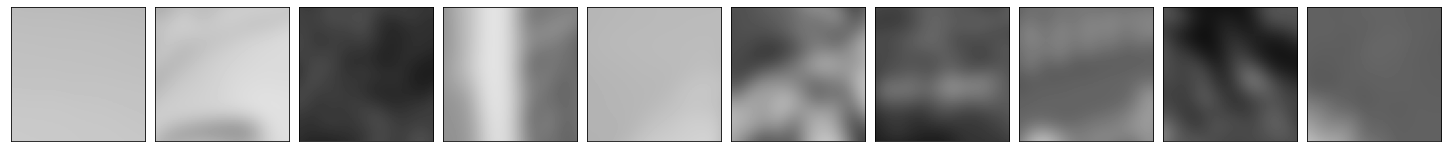

sample from augmented batch 3   image dims torch.Size([1, 64, 64])


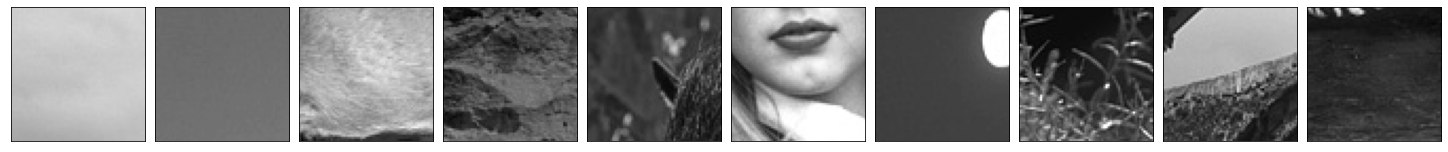

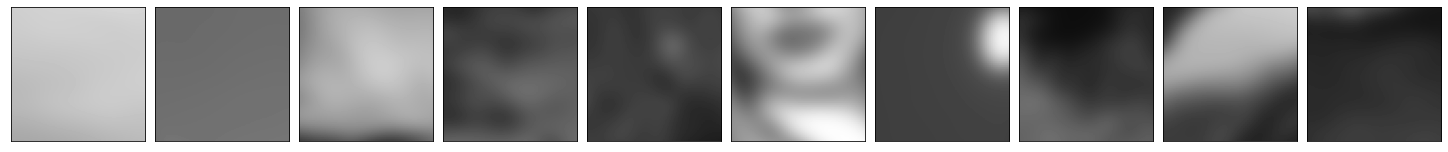

In [119]:
nRow = 1
nCol = 10
index_data = np.arange(nRow * nCol) # show only first images

for index_batch, (original, blur) in enumerate(dataloader_train_transform):
    print('sample from augmented batch', index_batch, '  image dims', original[0].size())
    plot_data_grid(original, index_data, nRow, nCol)     
    plot_data_grid(blur, index_data, nRow, nCol)


## shape of the data when using the data loader

In [120]:
(original_train, blur_train)  = dataset_train[0]
(original_test, blur_test)    = dataset_test[0]
(original_train_transform, blur_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the original in the training dataset:', original_train.shape)
print('shape of the blur in the training dataset:', blur_train.shape)
print('*******************************************************************')
print('shape of the original in the testing dataset:', original_test.shape)
print('shape of the blur in the testing dataset:', blur_test.shape)
print('*******************************************************************')
print('shape of the original in the training transform dataset:', original_train_transform.shape)
print('shape of the blur in the training transform dataset:', blur_train_transform.shape)
print('*******************************************************************')

*******************************************************************
shape of the original in the training dataset: torch.Size([1, 256, 256])
shape of the blur in the training dataset: torch.Size([1, 256, 256])
*******************************************************************
shape of the original in the testing dataset: torch.Size([1, 256, 256])
shape of the blur in the testing dataset: torch.Size([1, 256, 256])
*******************************************************************
shape of the original in the training transform dataset: torch.Size([1, 64, 64])
shape of the blur in the training transform dataset: torch.Size([1, 64, 64])
*******************************************************************


## neural network class

In [121]:
class Network(nn.Module):

    def __init__(self, in_channel=1, out_channel=1, dim_feature=8, threshold_ReLU=0.02):
        super(Network, self).__init__()
        
        # fully connected layers
        
        self.fully_connected1 = nn.Linear(dim_feature * 16, dim_feature * 16)
        self.fully_connected2 = nn.Linear(dim_feature * 16, dim_feature * 16)

        # 'encoder' layers
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.dim_feature = dim_feature

        self.conv_encode1 = nn.Conv2d(in_channel, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv_encode2 = nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True)
        
        self.conv_encode3 = nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv_encode4 = nn.Conv2d(dim_feature * 4, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv_encode5 = nn.Conv2d(dim_feature * 8, dim_feature * 16, kernel_size=3, stride=2, padding=1, bias=True)

        # 'decoder' layers
        
        self.conv_decode5 = nn.Conv2d(dim_feature * 16, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv_decode4 = nn.Conv2d(dim_feature * 8, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv_decode3 = nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True)
        
        self.conv_decode2 = nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv_decode1 = nn.Conv2d(dim_feature * 1, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv_out = nn.Conv2d(dim_feature * 1, out_channel, kernel_size=1, stride=1, padding=0, bias=True)

        # batchnorm layers
        self.ebn1 = nn.BatchNorm2d(dim_feature * 1)
        self.ebn2 = nn.BatchNorm2d(dim_feature * 2)
        self.dbn2 = nn.BatchNorm2d(dim_feature * 1)
        self.dbn1 = nn.BatchNorm2d(dim_feature * 1)
        
        self.ebn3 = nn.BatchNorm2d(dim_feature * 4)
        self.dbn3 = nn.BatchNorm2d(dim_feature * 2)
        
        self.ebn4 = nn.BatchNorm2d(dim_feature * 8)
        self.dbn4 = nn.BatchNorm2d(dim_feature * 4)
        
        self.ebn5 = nn.BatchNorm2d(dim_feature * 16)
        self.dbn5 = nn.BatchNorm2d(dim_feature * 8)

        # activation layers
        self.activation = nn.LeakyReLU(threshold_ReLU, inplace=True)
        self.activation_out = nn.Sigmoid()

    def forward(self, x):
        
        # 'encoder' layer 1
        x1 = self.conv_encode1(x)
        eb1 = self.ebn1(x1)
        e1 = self.activation(eb1)

        # possible 'encoder' layer 2
        x2 = self.conv_encode2(e1)
        eb2 = self.ebn2(x2)
        e2 = self.activation(eb2)
        
        # 'encoder' for layer3
        x3 = self.conv_encode3(e2)
        eb3 = self.ebn3(x3)
        e3 = self.activation(eb3)
        
        # 'encoder' for layer4
        x4 = self.conv_encode4(e3)
        eb4 = self.ebn4(x4)
        e4 = self.activation(eb4)
        
        # 'encoder' for layer5
        x5 = self.conv_encode5(e4)        
        eb5 = self.ebn5(x5)
        e5 = self.activation(eb5)
        
        # 'decoder' for layer5
        y5 = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(e5)
        y5 = self.conv_decode5(y5)
        db5 = self.dbn5(y5)
        d5 = self.activation(db5)
        
        # 'decoder' for layer4
        y4 = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(e4)
        y4 = self.conv_decode4(y4)
        db4 = self.dbn4(y4)
        d4 = self.activation(db4)
        
        # 'decoder' for layer3
        y3 = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(e3)
        y3 = self.conv_decode3(y3)
        db3 = self.dbn3(y3)
        d3 = self.activation(db3)

        # possible 'decoder' layer 2
        y2 = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(e2)
        y2 = self.conv_decode2(y2)
        db2 = self.dbn2(y2)
        d2 = self.activation(db2)

        # 'decoder' layer 1
        y1 = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(eb1)
        y1 = self.conv_decode1(y1)
        db1 = self.dbn1(y1)
        d1 = self.activation(db1)

        y1 = self.conv_out(d1)
        y = self.activation_out(y1)

        return y



## build network

In [122]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# try other optimizers?
adam_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## helper functions: accuracy (PSNR)

In [123]:
def compute_accuracy(prediction, label):

    # ssim

    def eval_step(engine, batch):
        return batch

    default_evaluator = Engine(eval_step)
    metric = SSIM(data_range=1.0)
    metric.attach(default_evaluator, 'ssim')
    state = default_evaluator.run([[prediction, label]])
    ssim = state.metrics['ssim']

    preds = prediction.squeeze().detach().numpy()
    targets = label.squeeze().detach().numpy()
    ssims = np.zeros(preds.shape[0])
    for i in range(preds.shape[0]):
        ssims[i] = structural_similarity(preds[i], targets[i], data_range=1)
    
    ssim = ssims.mean()

    # psnr

    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)
    mse_loss    = torch.mean((prediction - label) ** 2)

    if mse_loss == 0.0:
        psnr = 100
    else:
        psnr = 10 * torch.log10(1 / mse_loss)

    psnr = psnr.item()
    
    return psnr, ssim

## variables for the learning curve

In [124]:
loss_mean_train   = np.zeros(number_epoch)
loss_std_train    = np.zeros(number_epoch)
psnr_mean_train   = np.zeros(number_epoch)
psnr_std_train    = np.zeros(number_epoch)
ssim_mean_train   = np.zeros(number_epoch)
ssim_std_train    = np.zeros(number_epoch)

loss_mean_test    = np.zeros(number_epoch)
loss_std_test     = np.zeros(number_epoch)
psnr_mean_test    = np.zeros(number_epoch)
psnr_std_test     = np.zeros(number_epoch)
ssim_mean_test    = np.zeros(number_epoch)
ssim_std_test     = np.zeros(number_epoch)

## train and test functions

In [125]:
def train(model, dataloader):

    loss_epoch = []
    psnr_epoch = []
    ssim_epoch = []
    loss_criterion   = nn.MSELoss()

    model.train()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)
        
        # prediction
        prediction  = model(blur)

        # loss
        loss        = loss_criterion(prediction, original)

        # accuracy
        psnr, ssim    = compute_accuracy(prediction, original)
        
        optimizer.zero_grad()
        adam_optimizer.zero_grad()
        loss.backward()
        adam_optimizer.step()
        optimizer.step()

        loss_epoch.append(loss.item())
        psnr_epoch.append(psnr)
        ssim_epoch.append(ssim)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    psnr_mean_epoch = np.mean(psnr_epoch)
    psnr_std_epoch  = np.std(psnr_epoch)
    ssim_mean_epoch = np.mean(ssim_epoch)
    ssim_std_epoch  = np.std(ssim_epoch)

    loss    = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    psnr    = {'mean' : psnr_mean_epoch, 'std' : psnr_std_epoch}
    ssim    = {'mean' : ssim_mean_epoch, 'std' : ssim_std_epoch}

    return (loss, psnr, ssim)   


def test(model, dataloader):

    loss_epoch = []
    psnr_epoch = []
    ssim_epoch = []
    loss_criterion   = nn.MSELoss()

    model.eval()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)

        # prediction
        prediction  = model(blur)

        # loss
        loss        = loss_criterion(prediction, original)        
        
        # accuracy
        psnr, ssim    = compute_accuracy(prediction, original)

        loss_epoch.append(loss.item())
        psnr_epoch.append(psnr)
        ssim_epoch.append(ssim)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    psnr_mean_epoch = np.mean(psnr_epoch)
    psnr_std_epoch  = np.std(psnr_epoch)
    ssim_mean_epoch = np.mean(ssim_epoch)
    ssim_std_epoch  = np.std(ssim_epoch)

    loss    = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    psnr    = {'mean' : psnr_mean_epoch, 'std' : psnr_std_epoch}
    ssim    = {'mean' : ssim_mean_epoch, 'std' : ssim_std_epoch}

    return (loss, psnr, ssim)    


## Optimization

In [126]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, psnr_train, ssim_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    psnr_mean_train[i]  = psnr_train['mean']
    psnr_std_train[i]   = psnr_train['std']

    ssim_mean_train[i]  = ssim_train['mean']
    ssim_std_train[i]   = ssim_train['std']

    # ================================================================================
    # 
    # testing (validation)
    #
    # ================================================================================
    (loss_test, psnr_test, ssim_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    psnr_mean_test[i]  = psnr_test['mean']
    psnr_std_test[i]   = psnr_test['std']

    ssim_mean_test[i]  = ssim_test['mean']
    ssim_std_test[i]   = ssim_test['std']

    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:18<00:00,  1.59s/it]


# functions for visualizing the results 

## plot curve

In [127]:
# plot train and test metric along epochs
def plot_curve_error(train_mean, train_std, test_mean, test_std, x_label, y_label, title, identity=[]):

    plt.figure(figsize=(10,8))
    plt.title(title)

    alpha = 0.1
    
    plt.plot(range(len(train_mean)), train_mean, '-', color = 'red', label='train')
    plt.fill_between(range(len(train_mean)), train_mean - train_std, train_mean + train_std, facecolor = 'red', alpha = alpha) 

    plt.plot(range(len(test_mean)), test_mean, '-', color = 'blue', label='test')
    plt.fill_between(range(len(test_mean)), test_mean - test_std, test_mean + test_std, facecolor = 'blue', alpha = alpha) 
    
    if not identity==[]:
      plt.plot(range(len(identity)), identity, '--', color = 'green', label='identity')

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend()

    plt.tight_layout()
    plt.show()

---

# Results 

## train-set visualizations

[clean train images]


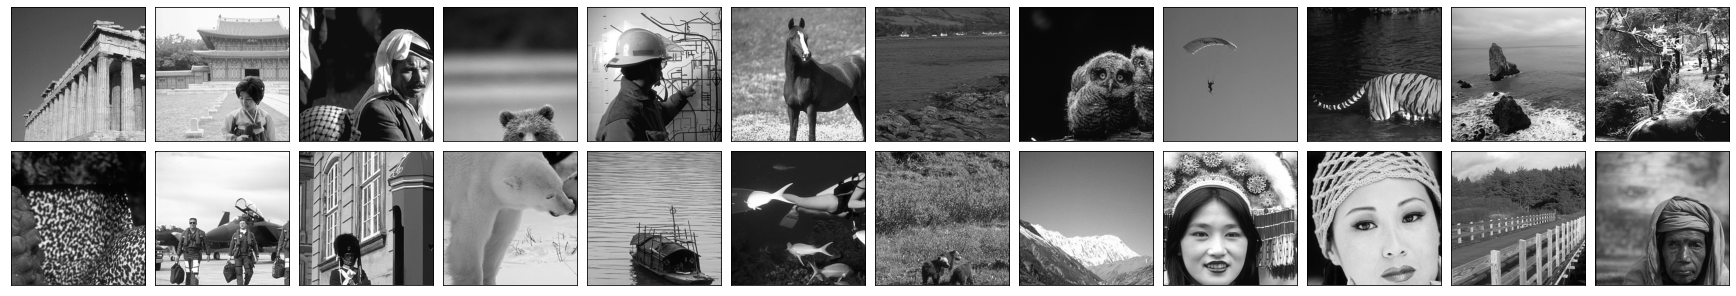

[blurry train images]


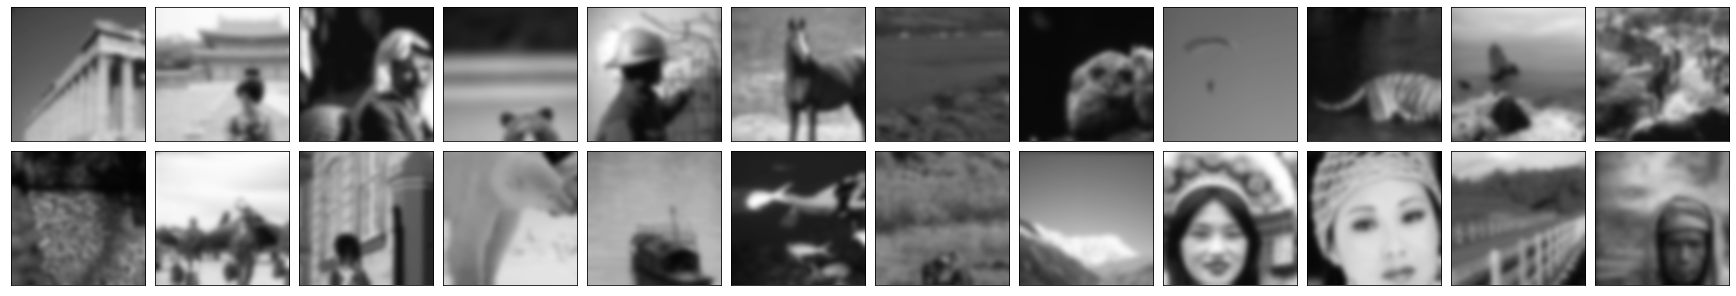

[deblurred train images]


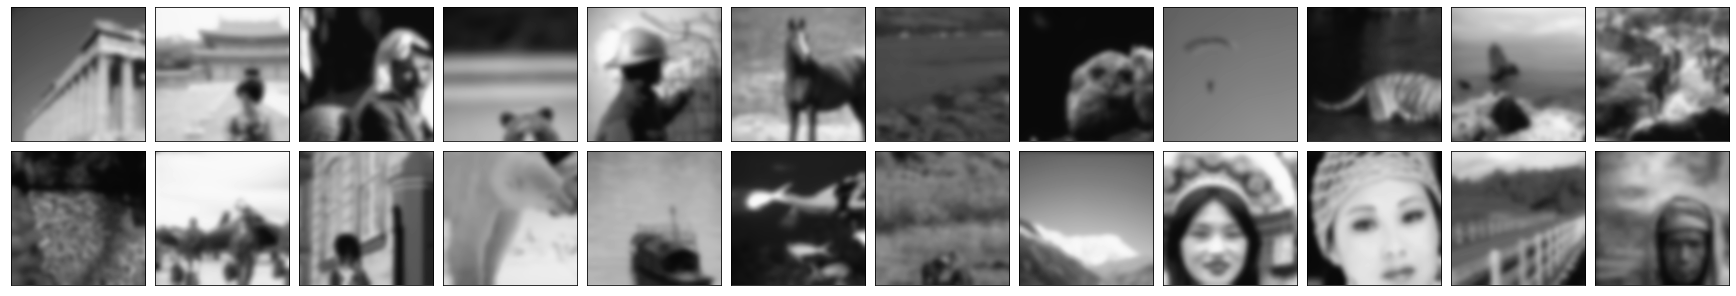

In [128]:
nRow = 2
nCol = 12
index_data                  = np.arange(0, nRow * nCol) # show only first images
originals_train, blurry_train = dataset_train[index_data]
originals_train              = originals_train[0]
blurry_train                 = blurry_train[0]

prediction_train = model(blurry_train.unsqueeze(dim=1).to(device))

print('[clean train images]')
plot_data_grid(originals_train, index_data, nRow, nCol)     
print('[blurry train images]')
plot_data_grid(blurry_train, index_data, nRow, nCol)   
print('[deblurred train images]')
plot_data_grid(prediction_train, index_data, nRow, nCol) 
   


## test-set visualizations

[clean test images]


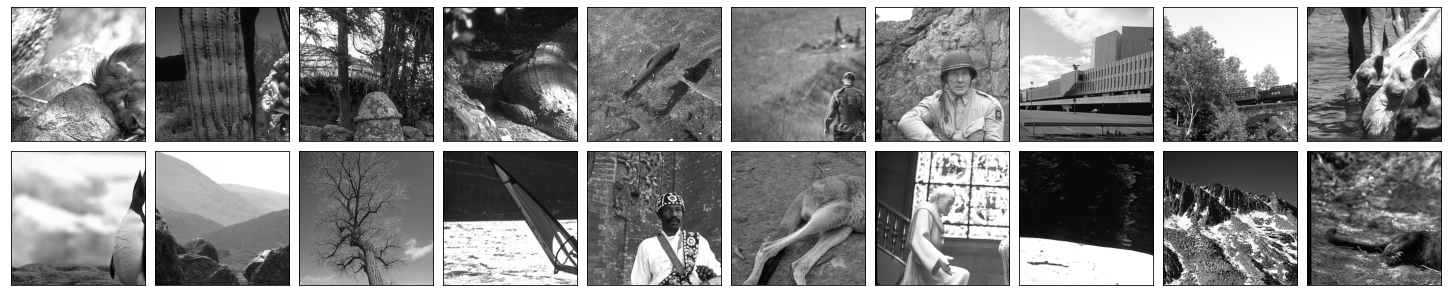

[blurry test images]


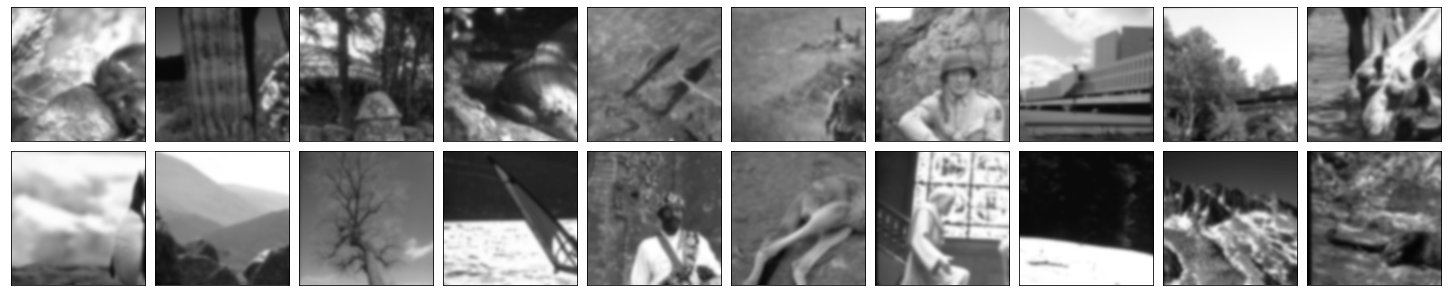

[deblurred test images]


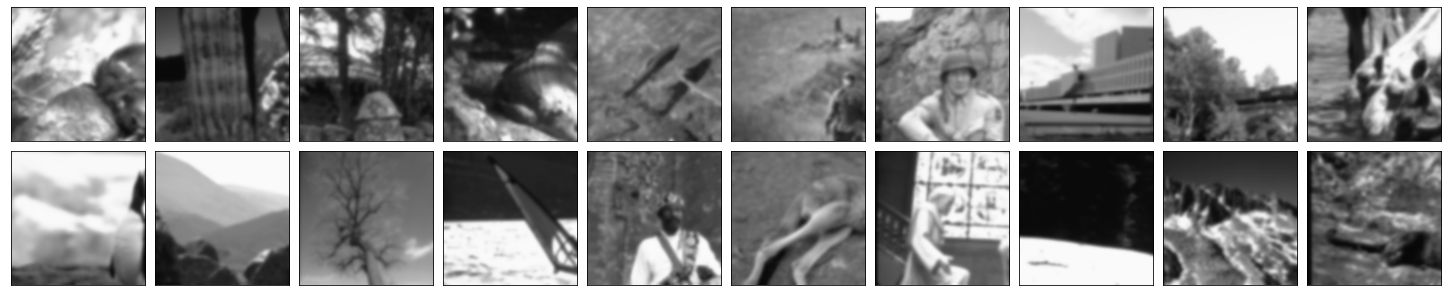

In [129]:
nRow = 2
nCol = 10
index_data                  = np.arange(0, nRow * nCol) # show only first images
originals_test, blurry_test = dataset_test[index_data]
originals_test              = originals_test[0]
blurry_test                 = blurry_test[0]

prediction_test = model(blurry_test.unsqueeze(dim=1).to(device))

print('[clean test images]')
plot_data_grid(originals_test, index_data, nRow, nCol)     
print('[blurry test images]')
plot_data_grid(blurry_test, index_data, nRow, nCol)   
print('[deblurred test images]')
plot_data_grid(prediction_test, index_data, nRow, nCol)    

## learning curves

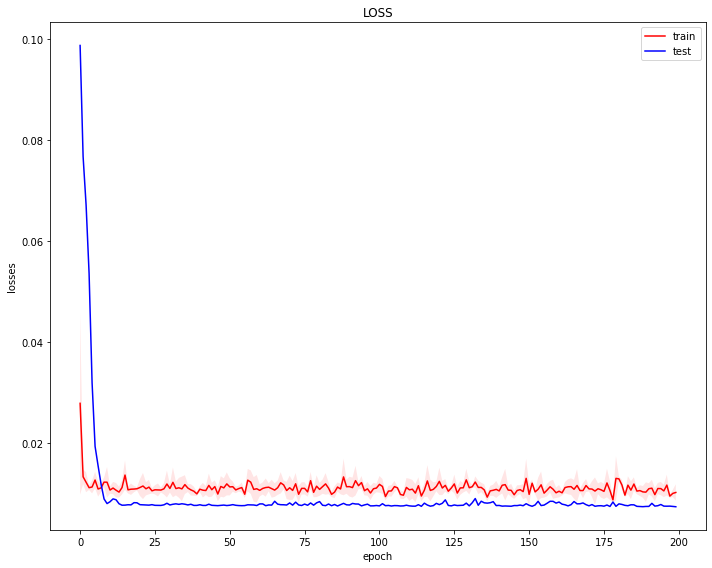

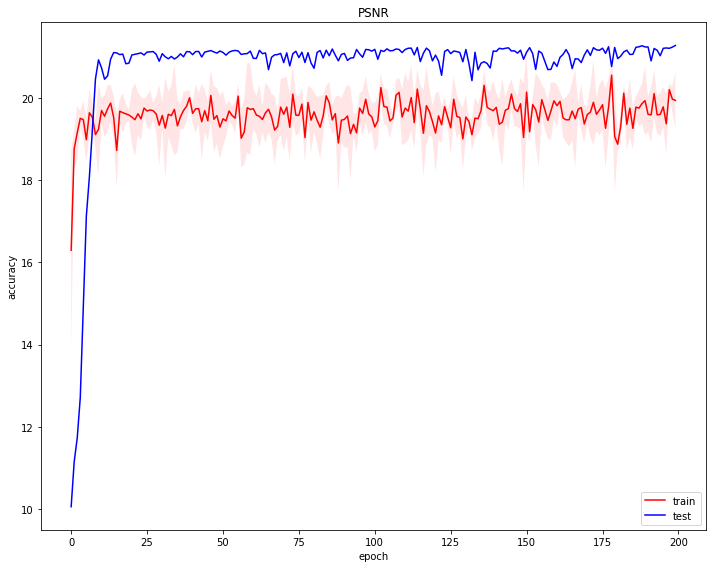

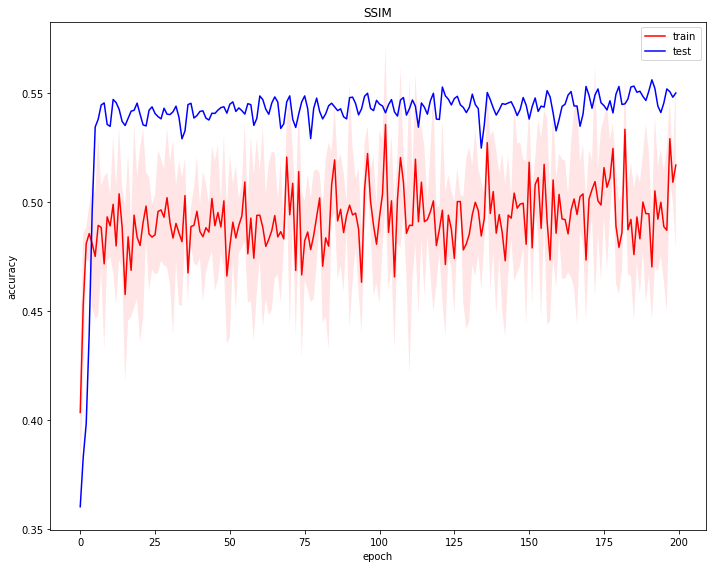

In [130]:
# loss
plot_curve_error(loss_mean_train, loss_std_train, loss_mean_test, loss_std_test, 'epoch', 'losses', 'LOSS')
# accuracy - PSNR
plot_curve_error(psnr_mean_train, psnr_std_train, psnr_mean_test, psnr_std_test, 'epoch', 'accuracy', 'PSNR')
# accuracy - SSIM
plot_curve_error(ssim_mean_train, ssim_std_train, ssim_mean_test, ssim_std_test, 'epoch', 'accuracy', 'SSIM')

# notice that the 'train' signals were computed each batch while the test signals are computed at the end of the epoch

## save your model (and submit as a separate file)

In [131]:
torch.save(model.state_dict(), './model.pth')

## evaluate on (public) test set (make sure that your model can load properly)

In [132]:
model = Network().to(device)
model.load_state_dict(torch.load('./model.pth'))
(loss_test, psnr_test, ssim_test) = test(model, dataloader_test)
print('Test PSNR: ', psnr_test['mean'])
print('Test SSIM: ', ssim_test['mean'])

Test PSNR:  21.271434783935547
Test SSIM:  0.5501648217792443


## Question: Are the outputs better than the inputs?
Compute in the block below the PSNR and SSIM on the test set when using the input (blurry) images as the prediction. Compare to your results above.

In [133]:
model = Network(dim_feature=8).to(device)
model.load_state_dict(torch.load('./model.pth'))

# Compute here the PSNR and SSIM of the blurry inputs: input_psnr_test and input_ssim_test

(loss_test, input_psnr_test, input_ssim_test) = test(model, dataloader_train)

# Then, uncomment these two rows:
print('Test PSNR: ', input_psnr_test['mean'])
print('Test SSIM: ', input_ssim_test['mean'])

Test PSNR:  20.343412399291992
Test SSIM:  0.5160694702687749


### Short (bulleted) description of your choices: (double-click to edit)

1.

2.

3.

4.

5.

6.
